# Waveform Analysis

[Any typo is on purpose]

This notebook will analyze the waveforms, find pulses in the waveform and determine:
* Pulse amplitude;
* Pulse charge (integrate area under pulse);
* Pulse timing (sample with pulses maximum amplitude).

Each section of the notebook will:

**1.** Define required parameters and load waveforms in dictionaries organized by channel.

**2.** Display a waveform for a given event. 

**3.** Find pulse information, as described above.

**4.** Store amplitude, charge and timing for each waveform and channel into a ROOT file.

Load up packages.

In [7]:
import uproot, numpy as np, matplotlib.pyplot as plt, platform
import matplotlib.colors as colors
from ipywidgets import IntProgress

# 1. Define Digitizer Params and Load Waveforms

## Digitizer Parameters for Unit Conversion

* The verticalScaleFactor conversts digitizer units to mV.
* It is the ratio between the number digitizer's vertical range and the number of bits on that axis.

In [8]:
mppc_DIGITIZER_FULL_SCALE_RANGE = 2.5 # Vpp
mppc_DIGITIZER_RESOLUTION       = 12 # bits
digiCounts = 2.**mppc_DIGITIZER_RESOLUTION
verticalScaleFactor = 1.e3*mppc_DIGITIZER_FULL_SCALE_RANGE/digiCounts; # mV/bank

* The horizontalScaleFactor converts sample number to nanoseconds.
* It considers that the digitizer was taking 3200000000 samples per second.

In [9]:
mppc_DIGITIZER_SAMPLE_RATE      = 3200000000 # S/s
horizontalScaleFactor = 1.e9/mppc_DIGITIZER_SAMPLE_RATE #ns/sample

## Load Waveforms from ROOT File

* Waveforms are store in a tree creatively named ```waveform_tree```.
* In this tree, each digitizer channel is in a branch called ```dtwave00``` ... ```dtwave07```.

The ```fetch_data``` function will:  
* Use ```uproot``` to access the tree and branches.  
* Create a dicitionary that contains keys from ```00``` up to ```07```, corresponding to each digitizer channel.
* A list of channels must be provided as ```channels = ['00', '01', '02'. '02']```.

In [10]:
def fetch_data(root_file_path:str, channels:list[str]=["00"], verticalScaleFactor=verticalScaleFactor) -> dict:
    
    # Digitizer specs
    mppc_DIGITIZER_FULL_SCALE_RANGE = 2.5 # Vpp
    mppc_DIGITIZER_RESOLUTION       = 12 # bits
    mppc_DIGITIZER_SAMPLE_RATE      = 3200000000 # S/s
    digiCounts = 2.**mppc_DIGITIZER_RESOLUTION
    
    # Find number of entries.
    with uproot.open(root_file_path) as root_file:
        N_entries = root_file["waveform_tree"].num_entries
        print("Number of waveforms per channel:", root_file["waveform_tree"].num_entries)

    # Fetch all waveforms per channel
    waveforms = {}
    branches = [f"dt5743_wave{ch}" for ch in channels]
    for i in range(0, len(branches)):
        with uproot.open(root_file_path) as root_file:
            waveforms_raw = root_file["waveform_tree"].arrays([branches[i]], library="np", entry_start = 0, entry_stop = N_entries)[branches[i]]
            waveforms[channels[i]] = waveforms_raw*verticalScaleFactor

    print("Channels retrieved: ", waveforms.keys())
    return waveforms

* To fetch all the waveforms for run 28, provide the path to the respective root file.

In [11]:
root_file_path = "./output00000028.root"
waveforms = fetch_data(root_file_path, channels=["00","01","02","03"])

Number of waveforms per channel: 409
Channels retrieved:  dict_keys(['00', '01', '02', '03'])


* As an example, to access waveforms 120 from channel '01', use:

In [12]:
waveforms['01'][120]

array([938.72070312, 936.88964844, 938.72070312, ...,   0.        ,
         0.        ,   0.        ])

# 2. Waveform Display

* To display the same event for each channel in two columns of plot.

In [13]:
def display_waveform(waveforms, event_number = 0, channels=["00", "01"], xscale = None, xlabel=None, ylabel=None, xrange=None, yrange=None, title=None, save:str=""): 

    ncols = 2
    nrows = int(len(channels)/2) if len(channels)%2==0 else int(len(channels)//2+1) 
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey=False, sharex=False, figsize=(8,5))
    axes = axes.flatten()

    # Print 
    i = 0
    if xscale != None:
        for ch in channels:
            axes[i].plot(np.arange(0,len(waveforms[ch][event_number]))*xscale, waveforms[ch][event_number], "black")
            i = i + 1
        if xrange == None: 
            axes[i].set_xlim(0, len(waveforms[ch][event_number])*xscale)
            i = i + 1
    
    else:
        for ch in channels:
            axes[i].plot(np.arange(0,len(waveforms[ch][event_number])), waveforms[ch][event_number], "black")
            i = i + 1
        if xrange == None: 
            axes[i].set_xlim(0, len(waveforms[ch][event_number])*xscale)
            i = i + 1

    # Set ranges
    for axi in axes:
        if xrange != None: axi.set_xlim(xrange)
        if yrange != None: axi.set_ylim(yrange)
        if xlabel != None: axi.set_xlabel(xlabel)
        if ylabel != None: axi.set_ylabel(ylabel)
        

    # fig.canvas.toolbar_visible = True
    # fig.canvas.header_visible = False
    # fig.canvas.resizable = True
    plt.tight_layout()
    if save != None:
        plt.savefig(save)
    
    # plt.show()

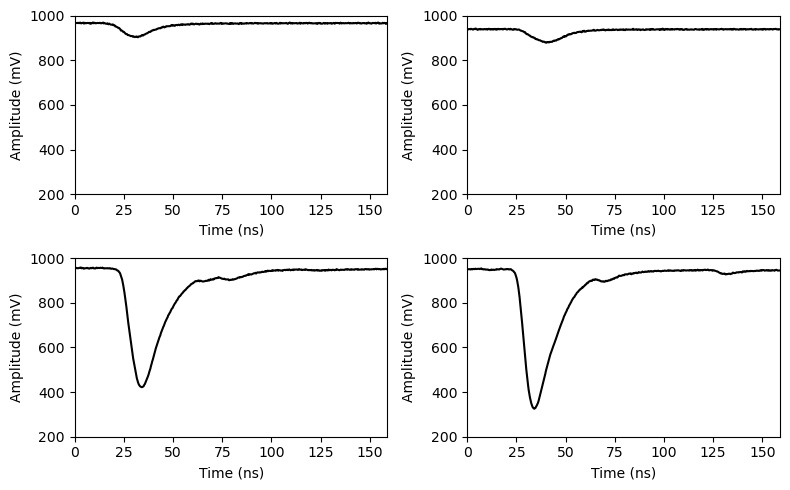

In [14]:
display_waveform(waveforms, 
                    event_number = 120, 
                    channels = ["00", "01", "02", "03"], 
                    xscale = horizontalScaleFactor, 
                    xrange = [0,159],
                    yrange = [200,1000],
                    ylabel = "Amplitude (mV)",
                    xlabel = "Time (ns)",
                    save   = "display_120.png" )

# 3. Pulse Information

* The function below takes the waveform of **one single channel** and analyzes each waveform.
* It finds the baseline, amplitude, charge and timing of a pulse in the waveform.
* Such information is stored in numpy arrays.

In [16]:
def analyze_data(waveforms, A=None, B=None, j_A=10, j_B=100, auto_window = False):

    # Initialize arrays with zeroes
    N_entries = len(waveforms)
    charge     = np.zeros(N_entries)
    amplitude  = np.zeros(N_entries)
    timing     = np.zeros(N_entries)

    # Add some eye candy
    progress = IntProgress(min=0, max=N_entries)
    display(progress)

    # If no specific time window, integrate charge over entire waveform.
    if A == None: A = 0
    if B == None: B = len(waveforms[0])

    # auto_window will integrate only around the pulse.
    if auto_window == False: print(f"Integration window: {A} Sa to {B} Sa.")
    if auto_window == True : print(f"Integration window: j_max-{j_A} to j_max+{j_B}.")

    # Loop over every waveform and find baseline, amplitude, charge and timing.
    for i in range(0, N_entries):
        baseline = np.average(waveforms[i][25:100])
        j_max = np.argmax(-1.*waveforms[i][A:B])
        timing[i] = j_max
        amplitude[i]   = -1.*(waveforms[i][j_max]-baseline)
        if auto_window == True:
            A = j_max - j_A
            B = j_max + j_B
            if A  <= 0:   A = 0
            if B  > 1024: B = 1024
        charge[i]     = -1.*np.sum(waveforms[i][A:B]-baseline)

        # Progress bar iteration
        if i%1000 == 0: 
            progress.value += 1000
 
    return charge, amplitude, timing

* To run the analysis for more than one channel, run it for each one.
* The following code will run the analysis and store pulse information in dictionaries.

In [17]:
charges, amplitudes, timings = {}, {}, {}
channels = ["00", "01", "02", "03"]
for ch in channels:
    charges[ch], amplitudes[ch], timings[ch] = analyze_data(waveforms[ch], A=None, B=None, j_A=10, j_B=100, auto_window = False)

IntProgress(value=0, max=409)

Integration window: 0 Sa to 1024 Sa.


IntProgress(value=0, max=409)

Integration window: 0 Sa to 1024 Sa.


IntProgress(value=0, max=409)

Integration window: 0 Sa to 1024 Sa.


IntProgress(value=0, max=409)

Integration window: 0 Sa to 1024 Sa.


* The pulse charges for channel ```'01'``` and amplitudes for channel ```'03'``` then accessed as:

In [19]:
charges['01']

array([484026.171875  , 483263.25683594, 482259.97721354, 487066.96777344,
       482395.05208333, 482634.71679688, 482689.86816406, 475802.97851562,
       439339.11132812, 482173.8688151 , 484276.171875  , 482388.39518229,
       482705.76985677, 484284.95279948, 483762.67089844, 484686.31184896,
       481945.58105469, 489752.62858073, 479826.73339844, 483413.6311849 ,
       479526.90429688, 482823.76302083, 474210.10742188, 482722.1110026 ,
       484863.18359375, 483055.12695312, 483216.13769531, 484097.0296224 ,
       484370.19042969, 482832.80436198, 484350.69986979, 481857.69042969,
       485506.03841146, 481696.875     , 486052.63671875, 482542.35839844,
       486651.83919271, 472005.8186849 , 481606.33951823, 484515.02278646,
       483603.19824219, 483264.2985026 , 482830.2327474 , 475764.99023438,
       480460.03417969, 484850.35807292, 484323.0875651 , 485534.9202474 ,
       483585.49804688, 483356.27441406, 480563.89160156, 484022.3063151 ,
       477392.02473958, 4

In [20]:
amplitudes['03']

array([948.65722656, 909.68424479, 940.41341146, 949.21061198,
       946.73665365, 911.43391927, 938.74511719, 941.34928385,
       935.67708333, 948.52701823, 930.14322917, 928.3203125 ,
       912.94759115, 906.2093099 , 948.09570312, 929.63053385,
       878.33658854, 947.54231771, 875.06510417, 941.09700521,
       884.11458333, 949.16992188, 878.82486979, 911.53971354,
       944.81608073, 946.23209635, 883.06477865, 945.86588542,
       940.34016927, 949.24316406, 902.07519531, 947.72135417,
       946.7203776 , 949.49544271, 949.73958333, 947.37141927,
       946.17513021, 941.58528646, 909.57845052, 946.875     ,
       949.81282552, 928.90625   , 949.92675781, 940.87727865,
       884.56217448, 945.87402344, 949.40592448, 926.1311849 ,
       947.48535156, 925.80566406, 841.30859375, 943.65234375,
       942.23632812, 928.99576823, 944.89746094, 902.61230469,
       892.89550781, 907.76367188, 935.29459635, 859.4156901 ,
       948.25846354, 941.84570312, 900.08138021, 943.84

# 4. Save Pulse Information

* Save pulse information in the goold old way of storing particle physics data -- a ROOT file.
* First organize data into a dictionary that contains the other dictionaries. 

In [25]:
data = {"amplitude":amplitudes, "charge":charges, "timing":timings}

* Define a function that calls uproot and stores that dictionary into a ROOT file.

In [26]:
def to_root(file_name, data):
    # @descrition: Save data dictionary to a tree in a root file
    # @params: _file_name_ with path to root file and _data_ dict.
    print(f"Saving to: {file_name}.root")
    with uproot.recreate(file_name+".root") as output_file:
        output_file["pulse_information"] = data

* Run that function to actually save the data.

In [27]:
to_root("./pulse_info_29.root", data)

Saving to: ./pulse_info_29.root.root


### Are you tired of using ROOT?

* Are you tired of defining classes, branches and trees just to store 3 arrays?
  
* ***numpy will store your dictionaries with a single liner.***
  
* [If interested, please refer to [this documentation.](https://numpy.org/doc/2.1/reference/generated/numpy.savez.html) ]

In [28]:
def to_npz(file_name, data):
    # Save data dictionary to an npz file
    # @params: _file_name_ with path to npz file and _data_ dict.   
    print(f"Saving to: {file_name}")
    np.savez_compressed(file_name, **data)

In [29]:
to_npz("./pulse_info_28.npz", data)

Saving to: ./pulse_info_28.npz
